In [1]:
# Tang Kit Lim (WQD190032)

import numpy as np 
import pandas as pd
import datetime
from pathlib import Path
from geopy.distance import distance

In [2]:
# load data from csv

data_directory = '../data/processed/'
Path(data_directory).mkdir(parents=True, exist_ok=True)

processed_transaction_csv = data_directory + 'edgeprop_transactions_processed.csv'
# transaction_csv = data_directory + 'edgeprop_transactions_processed.csv'

transactions = pd.read_csv(processed_transaction_csv, na_values=['None'], index_col=0)


## Data preparation for Model Training 

In [3]:
transactions = transactions[transactions['year'] >= 2017]

transactions['non_landed'] = transactions['non_landed'].astype('category')
transactions['project_id'] = transactions['project_id'].astype('category')

In [4]:
transactions.isna().sum()

project_id                     0
township                       0
property_type                  0
tenure                         0
area_sqft                      0
non_landed                     0
bedrooms                       0
psf                            0
price                          0
planning_region              300
state                          0
city                          24
median_psf                     0
median_price                   0
poi_nearby_education           0
poi_nearby_transportation      0
poi_nearby_healthcare          0
nearest_school                 0
nearest_train_station          0
nearest_hospital               0
total_poi_nearby               0
nearest_poi                    0
transaction_count              0
year                           0
dtype: int64

In [5]:
transactions.dropna(inplace = True)

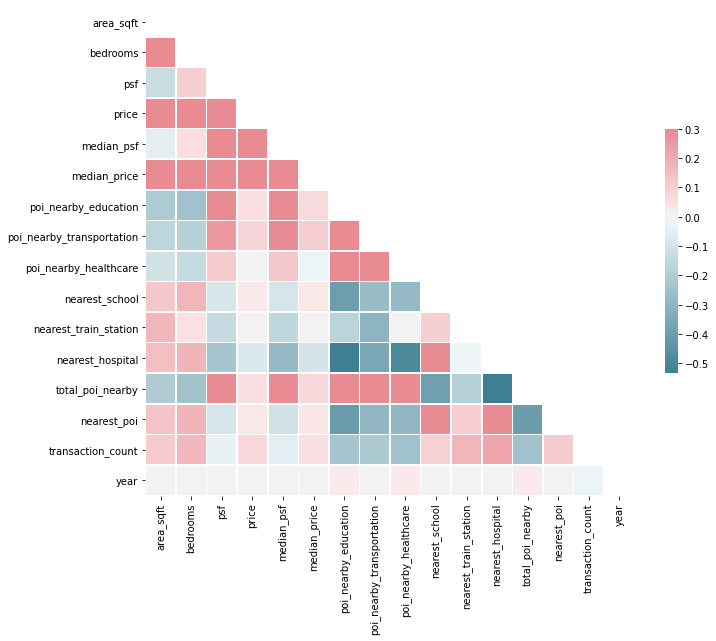

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

corr = transactions.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Feature Selections (Repeating)

In [7]:
# after rounds of evaluating the models, drop features with collinearity
# although including all features achieved highest accuracy predicting the testing set
# but advantages are not marginal and those informtion is hard for user input
numerical_features = [
    'area_sqft', 'bedrooms', 'nearest_poi'
    # 'poi_nearby_education','poi_nearby_transportation','poi_nearby_healthcare',
    # 'nearest_school', 'nearest_train_station', 'nearest_hospital', 'total_poi_nearby',
]

categorical_features = [
    'city', 'project_id', 'property_type', 'tenure', 'state' #, 'non_landed', 'planning_region'
]

features = numerical_features + categorical_features
target = 'price'

transactions = transactions[features + [target]]

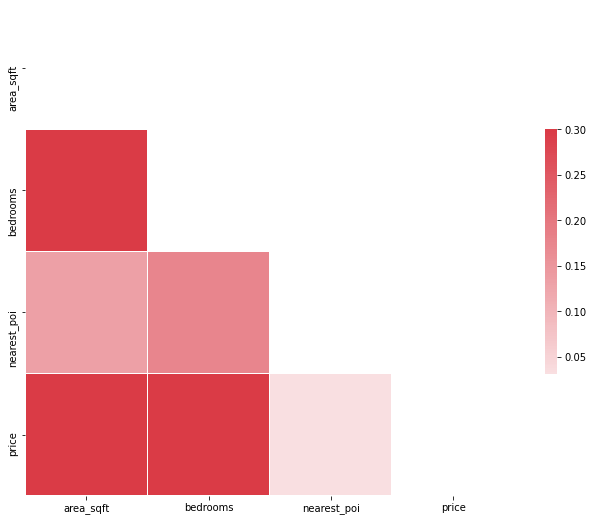

In [8]:
# correlation heatmap for the selected (numerical) features only
corr = transactions.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Model Training & Evaluation (Repeating)

In [9]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [10]:
x = transactions[features]
y = transactions[target]

column_transform = make_column_transformer(
    (MinMaxScaler(), numerical_features),
    (OneHotEncoder(), categorical_features),
    remainder='passthrough'
)

column_transform.fit_transform(x)

preprocess = make_pipeline(
    column_transform
)
preprocess.fit_transform(x)

linear_regression = LinearRegression()


In [11]:
pipeline = make_pipeline(preprocess, linear_regression)

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 17)

In [13]:
pipeline.fit(x, y)
print("Score: %f" % pipeline.score(x_test, y_test))

pd.DataFrame({
    'predicted_price': y_test,
    'price': pipeline.predict(x_test)
})

Score: 0.818862


,predicted_price,price
147938,275000,246248.521670
110348,555000,469914.517633
20642,115000,121128.792110
109427,600000,552633.255529
169135,370000,347177.967909
...,...,...
23587,880000,556513.729262
182666,200000,171981.787874
139004,595800,570342.280644
61031,490000,461129.346592


In [14]:
from pickle import dump
dump(pipeline, open('../data/model.pkl', 'wb'))


In [15]:
x_test

,area_sqft,bedrooms,nearest_poi,city,project_id,property_type,tenure,state
147938,850.0,3.0,1141.389883,Bandar Kinrara Puchong,10143,Condominium/Apartment,Leasehold,Selangor
110348,1195.0,2.0,112.256317,Petaling Jaya,8546,Condominium/Apartment,Leasehold,Selangor
20642,646.0,3.0,289.083517,Damansara Damai,13957,Flat,Leasehold,Selangor
109427,1722.0,4.0,636.867263,Klang,22765,Terrace House,Freehold,Selangor
169135,1249.0,3.0,984.974065,Cheras South,11905,Condominium/Apartment,Freehold,Selangor
...,...,...,...,...,...,...,...,...
23587,1647.0,4.0,400.440278,Klang,8852,Terrace House,Freehold,Selangor
182666,1001.0,3.0,165.827104,Johor Bahru,14092,Condominium/Apartment,Leasehold,Johor
139004,1399.0,3.0,1858.025754,Semenyih,24979,Terrace House,Freehold,Selangor
61031,2562.0,4.0,551.719060,Bukit Mertajam,13124,Semi-Detached House,Freehold,Penang
